In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from scipy.optimize import curve_fit
import re
import math

In [14]:
dr = '/Users/litz/Documents/GitHub/data/'
files = glob.glob(dr + "model_KIC9773821/*.csv")
temp = []
for filename in files:
    df0 = pd.read_csv(filename, index_col=0)
    temp.append(df0)
starset_seismo = pd.concat(temp, axis = 0, ignore_index=True)
starset_seismo = starset_seismo.loc[( (starset_seismo['surf_a'] <= 9000.0) &
                                      (starset_seismo['surf_b'] >= 0.0)
                                    )]
starset_seismo

,evol_stage,star_mass,star_age,effective_T,log_g,radius,luminosity,star_feh,delta_nu,nu_max,...,lk_nu_max,lk_delta_nu,lk_delta_nu_fit,lk_delta_Pg,lk_total,lk_l0,surf_a,surf_b,lk_global,lk_new
0,2,2.398709,-0.321440,5136.996250,2.942843,8.659877,46.918354,0.001475,8.787713,105.150747,...,0.025329,0.346906,0.485001,0.041307,0.037875,0.570153,-0.517208,1.750607,0.729070,0.023630
2,2,2.798683,-0.379700,5173.576144,2.962454,9.145223,53.831229,0.200370,8.744957,109.618161,...,0.024264,0.362030,0.486449,0.459316,0.103259,0.661176,-0.453440,0.860713,0.186044,0.077753
3,3,2.105674,-0.137140,5304.538227,2.919633,8.333426,49.399189,-0.389104,8.842746,98.091862,...,0.023007,0.327025,0.488262,0.994609,0.012632,0.846709,-0.182970,4.910870,0.011044,0.012799
4,3,2.514830,-0.276478,5246.255903,2.947675,8.817820,52.917910,-0.187070,8.783846,105.214178,...,0.025327,0.348287,0.488948,0.304155,0.079843,0.933040,-0.186733,2.160413,0.207056,0.080864
5,3,2.510364,-0.214297,5312.279745,2.944457,8.842689,55.946736,-0.187070,8.842408,103.786404,...,0.025255,0.327148,0.483874,0.446439,0.053480,0.553366,-0.508835,2.289122,0.095753,0.032554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,3,2.232144,-0.173665,4978.921582,2.931406,8.464531,39.557539,0.010582,8.794750,104.030713,...,0.025282,0.344386,0.486386,0.159707,0.124096,0.856710,-0.229010,3.559577,0.595374,0.168071
2043,3,2.232132,-0.173508,4981.671813,2.935678,8.422973,39.256682,0.010582,8.860482,105.030248,...,0.025330,0.320549,0.479396,0.125401,0.096903,0.104469,-1.041001,1.663965,0.599594,0.016207
2044,2,2.678654,-0.450134,5308.328562,2.955852,9.015229,57.978511,0.000047,8.797932,106.585252,...,0.025202,0.343244,0.483157,0.446530,0.095687,0.484350,-0.584797,1.633684,0.165817,0.073992
2045,3,2.434838,-0.152977,5072.654671,2.947045,8.682745,44.847440,0.211725,8.780486,106.844254,...,0.025157,0.349485,0.487574,0.424869,0.121684,0.560226,-0.544990,1.095183,0.220003,0.108042


Tanda: we still use the same modes

In [15]:
def prob(para, lk, start, end, binsize,shift):
    n = int((end - start + shift)/binsize)
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        x[i] = start + shift + i*binsize + 0.5*binsize
        yindex = np.where((para >= (start + shift + i*binsize)) &
                          (para < (start + shift + (i+1)*binsize))
                         )
        yyy = yindex[0]
        if (len(yyy) > 0):
            y[i] = np.sum(lk[yyy])
    return x, y

In [16]:
def kb95(X, a, b):
    x1, x2 = X
    return x1 - a*x2**b

def surface_correction(obs_freq, mode_freq, nu_max, sc_method):
    if (sc_method == 'kb95'):
        #kb 95 nu_obs - nu_model = a*(nu_obs/nu_max)**b        
        popt, pcov = curve_fit(kb95, (obs_freq, obs_freq/nu_max), mode_freq)
        a, b = popt
        a_e, b_e = pcov
    return a, b

def correct_sc(obs_freq, mode_freq, nu_max, sc_method, a, b):
    if (sc_method == 'kb95'):
        new_mode_freq = mode_freq + a*(obs_freq/nu_max)**b
    return new_mode_freq

def seismo_lk(obs_freq,obs_freq_e,mode_freq, n):
    chi2 = np.sum(1.0/n*((obs_freq - mode_freq)**2.0/2.0/obs_freq_e**2.0))
    lk = math.exp(0.0 - chi2)
    return lk


Text(0.5, 1.0, 'Models for KIC 9773821')

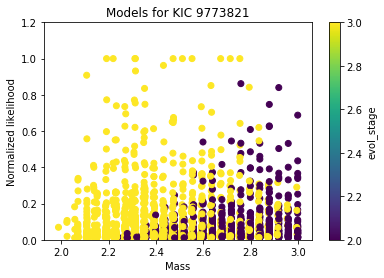

In [17]:
fig, ax = plt.subplots()
s = ax.scatter(starset_seismo['star_mass'],starset_seismo['lk_new'], c = starset_seismo['evol_stage'])
ax.set_ylim([1.5,3.5])
ax.set_ylim([0.000, 1.2])
plt.xlabel('Mass')
plt.ylabel('Normalized likelihood')
plt.colorbar(s,ax=ax).set_label('evol_stage')
plt.title('Models for KIC 9773821')

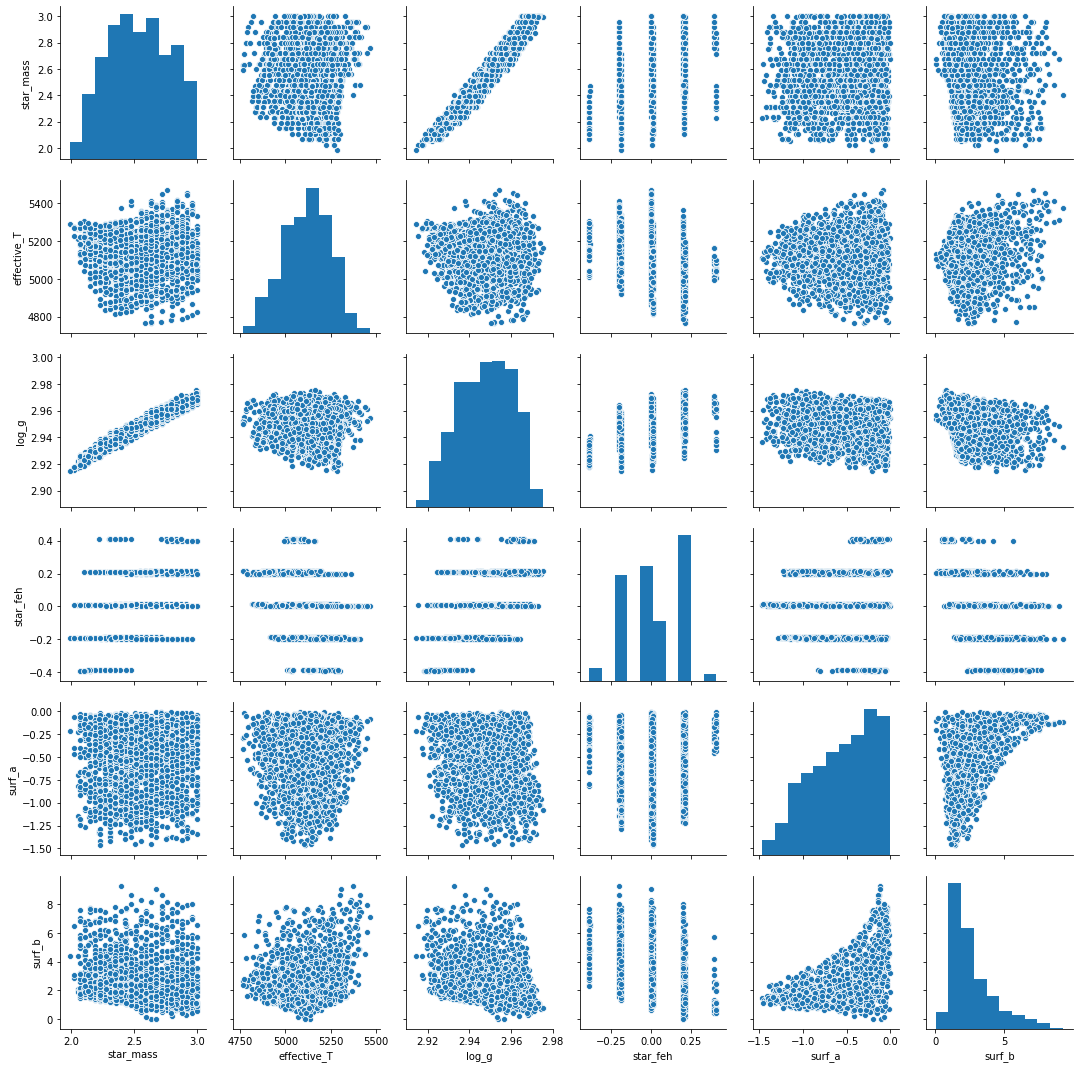

In [18]:
surface_set = starset_seismo.loc[( (starset_seismo['surf_a'] <= 9000.0) &
                                   (starset_seismo['lk_new'] >= 0.01) &
                                   (starset_seismo['surf_b'] >= 0.0)
                                 )]

sns.pairplot(surface_set[['star_mass','effective_T','log_g','star_feh',
                            'surf_a', 'surf_b']])